In [1]:
import pandas as pd 
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import shap
from sklearn.preprocessing import LabelEncoder

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
shap.initjs()

In [6]:
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

# read in data 

data based on the UCI diabetes set 
https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

full data attributes described here: 
https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub

In [18]:
obesity = pd.read_csv("obesity.csv")

In [19]:
encoder = LabelEncoder()
encoder.fit(obesity["NObeyesdad"])
encoded_Y = encoder.transform(obesity["NObeyesdad"])

In [20]:
obesity["obesity_encoded"] = encoded_Y

In [21]:
obesity = obesity.drop("NObeyesdad", axis=1)

In [22]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,obesity_encoded
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,5
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,6


# data properties
make some plots to explore the data attributes and their underlying properties 

# data preparation

In [23]:
def make_boolean(column): 
    return column.replace({"yes":1, "no":0})    

In [24]:
def make_scale(column): 
    return column.replace({"no":0, "Sometimes":1, "Frequently":2, "Always":3})    

In [25]:
# numerical data is best for a ML algorithm. We can start by making the yes/no columns boolean 

obesity["family_history_with_overweight"] = make_boolean(obesity["family_history_with_overweight"])
obesity["FAVC"] = make_boolean(obesity["FAVC"])
obesity["SMOKE"] = make_boolean(obesity["SMOKE"])
obesity["SCC"] = make_boolean(obesity["SCC"])

In [26]:
# recode sex as boolean too 

obesity["Gender"] = obesity["Gender"].replace({"Female":1, "Male":0})

In [27]:
# we also have categorical data, that is a scale - "no" on one end of the spectrum, 
# "always" on the other end. this data could be coded a few ways, but here I chose 
# numerically, with "no" being 0, and "always" being 4 

obesity["CALC"] = make_scale(obesity["CALC"])
obesity["CAEC"] = make_scale(obesity["CAEC"])

In [28]:
# lastly, we have strictly categorical data. there is no inherent numbering between the methods 
# of transportation column- "Public_transportation" isn't necessarily higher than "walking". 
# so instead, we one hot encode these. This transforms them into numbers that work with the 
# algorithm, but keeps the inherent lack of relationship between the variables 

transport = pd.get_dummies(obesity["MTRANS"])
obesity = obesity.drop("MTRANS", axis = 1)
obesity = obesity.join(transport)

In [29]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,obesity_encoded,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0,0.0,1.0,0,1,0,0,0,1,0
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,1,3.0,0.0,1,1,0,0,0,1,0
2,0,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,0,2.0,1.0,2,1,0,0,0,1,0
3,0,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,0,2.0,0.0,2,5,0,0,0,0,1
4,0,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0,0.0,0.0,1,6,0,0,0,1,0


# neural network 

In [104]:
# here we are separating our data into outcome and input variables 
Y = pd.get_dummies(obesity["obesity_encoded"])
X = obesity.drop("obesity_encoded", axis=1)

In [105]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [32]:
# create a simple neural network with 2 8-node layers ("dense" means a "normal" NN layer)
# and one output layer, that gives our one dimensional output. 
# the "sigmoid" function gives us an output that is between 0/1, which is consistent with 
# our binary classification task 

model = Sequential()
model.add(Dense(8, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

2021-10-06 15:57:28.401282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# this defines more parameters about how the model is trained. 
# we ust a binary cross entropy loss function because we have a binary classification task 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### model training 

In [34]:
# we train the data in "epochs"- the more epochs, the more the data is run though the NN 
# for something simple like this, 15 epochs is fine, but in the future we might want to fit more 

history = model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=5, verbose=0)

2021-10-06 15:57:32.188293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


### assessing model training

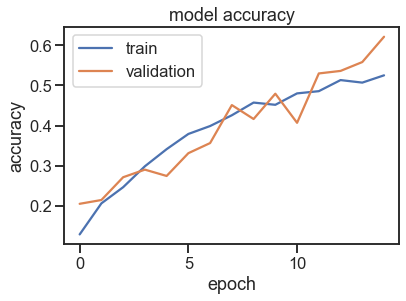

In [35]:
# we can assess how well the model /training/ step is doing (so not testing yet) by looking at how 
# accurate the model is on our training set. The ideal is for this to be as close to one as possible
# if it's not at one, we might want more layers, more epochs, or to revisit how our model is defined

plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left')
plt.show()

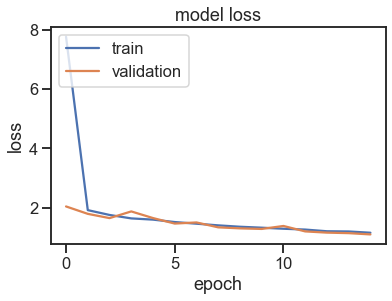

In [36]:
# here we are also evaluating the training, looking at the loss function. a NN tries to minimize 
# the loss, so we want this number to be as close to 0 as possible 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left')
plt.show()

### evaluating the model 

In [54]:
# here we are finally seeing how well the model does on our test set in terms of 
# average loss (first number) and average accuracy (second number)
score = model.evaluate(x_test, y_test, verbose=0)
score

[0.9400609135627747, 0.6287878751754761]

In [121]:
# here we can see the predictions 
# the predictions are probabilities that an individual is overeight or not 
# less than 0.5 is not overweight, greater or equal is overweight 
predictions = model.predict(x_test)
predictions.round(1)

array([[0. , 0. , 0. , ..., 0.3, 0. , 0. ],
       [0. , 0. , 0.3, ..., 0.4, 0. , 0.1],
       [0. , 0.1, 0.1, ..., 0. , 0.4, 0.2],
       ...,
       [0. , 0.1, 0.4, ..., 0.1, 0.1, 0.2],
       [0. , 0. , 0. , ..., 0.8, 0. , 0. ],
       [0. , 0. , 0.1, ..., 0.3, 0.1, 0. ]], dtype=float32)

In [56]:
# this numpy function makes everything the classic 0/1 that we expect 
np.rint(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [58]:
# a confusion matrix can help us visualize where the model is misclassifying individuals 
confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_test, np.rint(predictions))

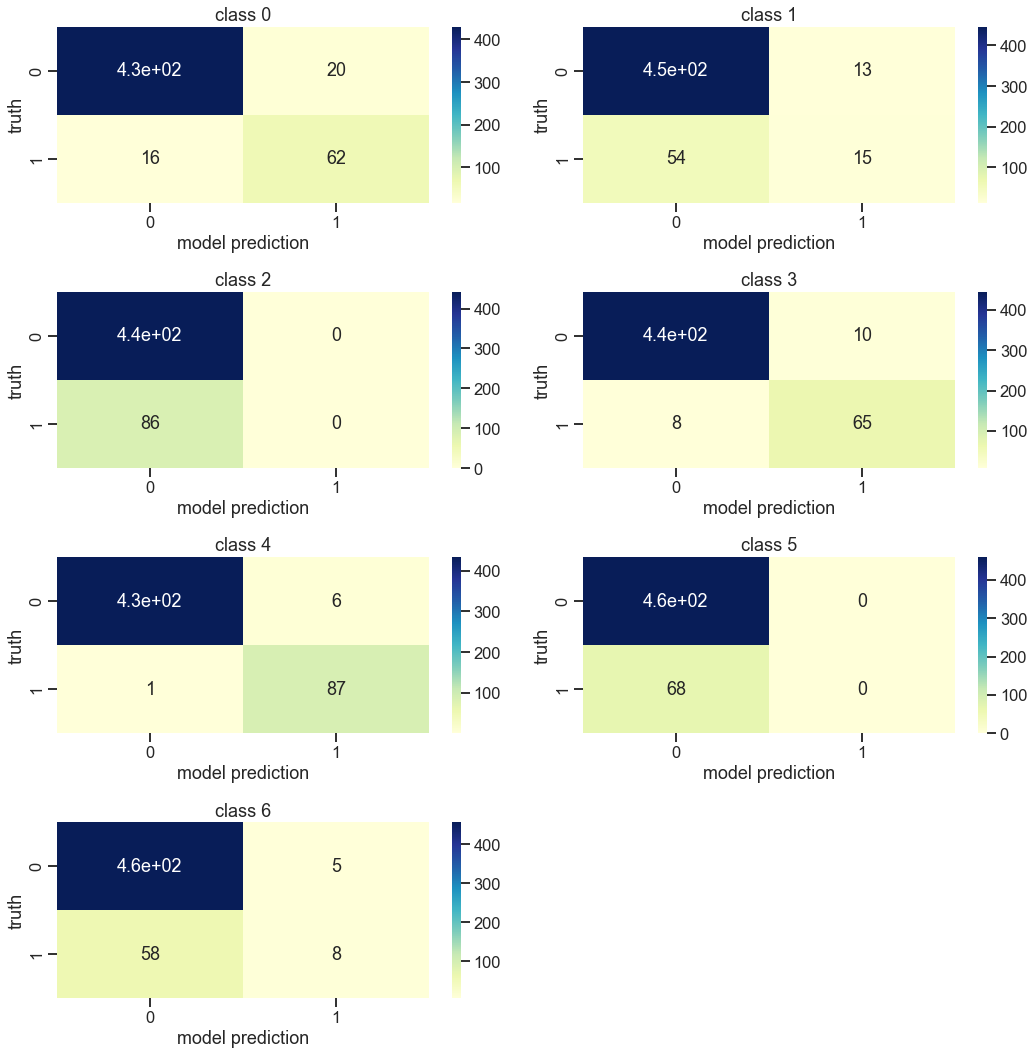

In [87]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))

for i in range(4):
    for j in range(2): 
        plot_num = (i*2)+j
        
        if plot_num < len(confusion_matrix):
            sns.heatmap(confusion_matrix[plot_num], annot=True, cmap="YlGnBu", ax=ax[i, j])
            ax[i, j].set_xlabel("model prediction")
            ax[i, j].set_ylabel("truth")
            ax[i, j].set_title(f"class {plot_num}")

plt.delaxes(ax=ax[i, j]) 
plt.tight_layout()
plt.show()

In [124]:
y_test.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [126]:
predictions

array([[2.53400430e-08, 1.18587355e-04, 3.77367251e-02, ...,
        2.94622213e-01, 1.87440384e-02, 1.26382522e-02],
       [4.64616187e-06, 7.04807043e-03, 2.96305209e-01, ...,
        4.03732389e-01, 4.98654917e-02, 8.59770700e-02],
       [3.65215912e-03, 6.00456707e-02, 9.60354879e-02, ...,
        1.39020476e-02, 4.43040103e-01, 2.30205178e-01],
       ...,
       [1.14520160e-04, 5.36352359e-02, 4.30950582e-01, ...,
        1.19370617e-01, 9.64337587e-02, 2.39739522e-01],
       [1.30926867e-10, 9.69463417e-06, 2.26772260e-02, ...,
        7.99866259e-01, 1.11954007e-03, 2.03027064e-03],
       [1.09939572e-06, 1.37908885e-03, 1.05768457e-01, ...,
        2.73077220e-01, 5.23900427e-02, 4.92885560e-02]], dtype=float32)

In [127]:
classification_report(y_test.values, np.rint(predictions))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


'              precision    recall  f1-score   support\n\n           0       0.71      0.60      0.65        78\n           1       0.00      0.00      0.00        69\n           2       0.00      0.00      0.00        86\n           3       0.80      0.59      0.68        73\n           4       1.00      0.84      0.91        88\n           5       0.33      0.01      0.03        68\n           6       0.00      0.00      0.00        66\n\n   micro avg       0.83      0.31      0.45       528\n   macro avg       0.41      0.29      0.32       528\nweighted avg       0.42      0.31      0.35       528\n samples avg       0.31      0.31      0.31       528\n'

# feature importance

In [107]:
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train, 100))
shap_values = explainer.shap_values(x_test, nsamples=100)

  0%|          | 0/528 [00:00<?, ?it/s]

In [109]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], 
                pd.DataFrame(x_test).iloc[0,:])

In [117]:
shap.force_plot(explainer.expected_value[2], shap_values[2], x_test)

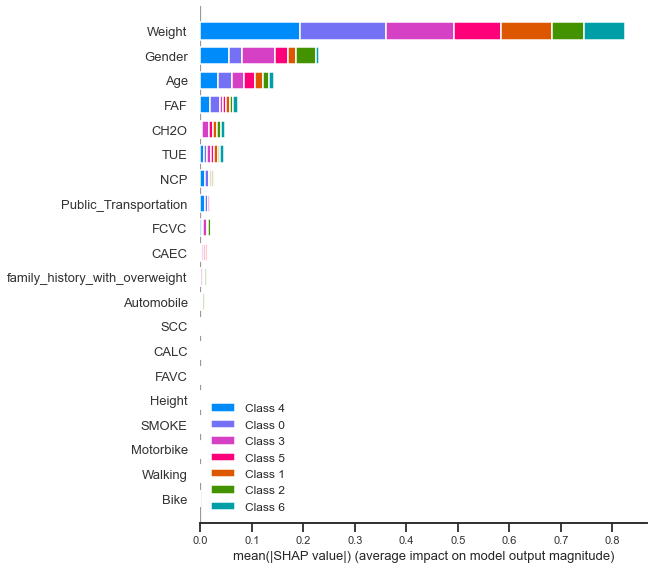

In [118]:
shap.summary_plot(shap_values, X)